In [137]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd, xgboost, numpy as np, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.utils import to_categorical

In [138]:
#news_scraping_results = pd.read_csv("./news_scraping_results_and_label.csv")
news_scraping_results = pd.read_csv("./1105_news_data_preprocessed_labeled.csv")
news_scraping_results = news_scraping_results.dropna(subset=['sentiment'])

In [139]:
tickers_list = pd.read_csv("./tickers_list.csv")

In [140]:
#suspended_ticker_news = news_scraping_results[news_scraping_results['SYMBOL'].isin(tickers_list['Symbol'].values)]
suspended_ticker_news = pd.read_csv('suspended_ticker_news.csv')

In [141]:
active_ticker_news = news_scraping_results[~news_scraping_results['SYMBOL'].isin(tickers_list['Symbol'].values)]

In [142]:
balanced_news = active_ticker_news[active_ticker_news['sentiment'] == 'negative'].reset_index()
balanced_news = balanced_news.append(active_ticker_news[active_ticker_news['sentiment'] == 'positive'].reset_index()[:2170], ignore_index=True)
balanced_news = balanced_news.append(active_ticker_news[active_ticker_news['sentiment'] == 'neutral'].reset_index()[:2170], ignore_index=True)

In [144]:
#balanced_news = pd.read_csv('balanced_active_news.csv')

In [145]:
suspended_balanced_news = balanced_news.append(suspended_ticker_news.reset_index(), ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [146]:
neg_news = balanced_news[balanced_news['sentiment']=='negative']
neg_string = []
for t in neg_news.CONTENT:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

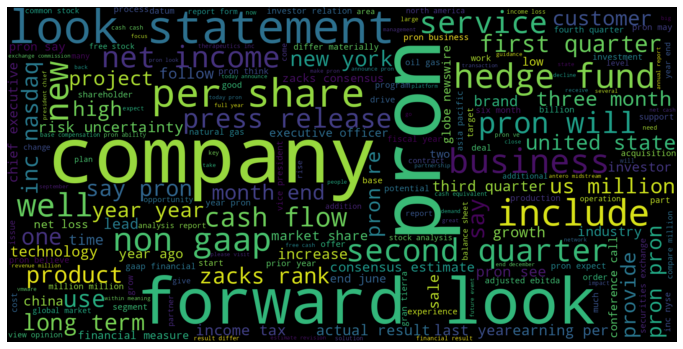

<Figure size 432x288 with 0 Axes>

In [147]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('1_negative_wordcloud.png')

In [148]:
pos_news = balanced_news[balanced_news['sentiment']=='positive']
pos_string = []
for t in pos_news.CONTENT:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

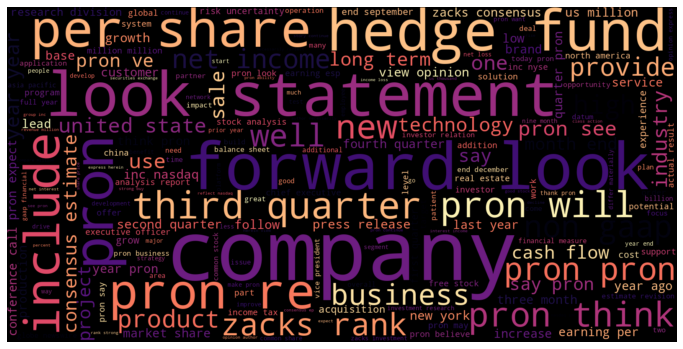

<Figure size 432x288 with 0 Axes>

In [149]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('1_positive_wordcloud.png')

In [150]:
neu_news = balanced_news[balanced_news['sentiment']=='neutral']
neu_string = []
for t in neu_news.CONTENT:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')

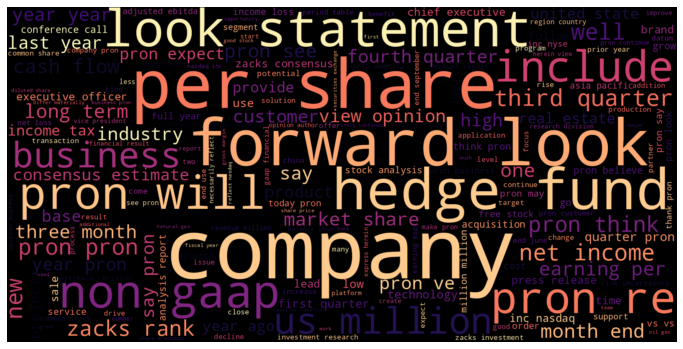

<Figure size 432x288 with 0 Axes>

In [151]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('1_neutral_wordcloud.png')

In [43]:
# whole dataset with suspended and balanced active stock
#X, y = suspended_balanced_news[['CONTENT']].values.flatten().astype(str), suspended_balanced_news[['sentiment']].values.flatten().astype(str)

In [152]:
# whole dataset with suspended and balanced active stock
X, y = suspended_balanced_news[['CONTENT']].values.flatten(), suspended_balanced_news[['sentiment']].values.flatten()

In [153]:
# dataset without suspended stock 
Xb, yb = balanced_news[['CONTENT']].values.flatten(), balanced_news[['sentiment']].values.flatten()

In [154]:
# suspended stock dataset
Xs, ys = suspended_ticker_news[['CONTENT']].values.flatten(), suspended_ticker_news[['sentiment']].values.flatten()

In [155]:
# split the dataset into training and validation datasets 
train_X, test_X, train_y, test_y = model_selection.train_test_split(Xb, yb, test_size=0.2, random_state=42)

In [156]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [157]:
#train_y = to_categorical(train_y)
#test_y = to_categorical(test_y)

In [158]:
test_ys = encoder.fit_transform(ys)

In [17]:
#test_ys = to_categorical(test_ys)

In [18]:
#encode_y = encoder.fit(y)

In [19]:
#encode_y.classes_

In [20]:
#pd.DataFrame(encode_y, columns=['sentiment']).to_csv('balanced_encoded_labels.csv')

In [159]:
# create a count vectorizer object 
count_vect = CountVectorizer()
count_vect.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [160]:
neg_doc_matrix = count_vect.transform(neg_news.CONTENT)
pos_doc_matrix = count_vect.transform(pos_news.CONTENT)
neu_doc_matrix = count_vect.transform(neu_news.CONTENT)

neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))

term_freq_df = pd.DataFrame([neg,pos,neu],columns=count_vect.get_feature_names()).transpose()

In [161]:
document_matrix = count_vect.transform(balanced_news.CONTENT)

In [162]:
balanced_news[balanced_news['sentiment']=='negative'].tail()

,index,SYMBOL,SITE_NAME,URL,PUBLISH_TIME,SCRAPED_TIME,TITLE,CONTENT,sentiment
2165,7353,SANW,The Straits Times,https://www.straitstimes.com/multimedia/the-bi...,2019-11-01 09:33:18+00:00,2019-11-05-10-16,The Big Story: New ISIS leader appointed; and ...,singapore catch up with the hot topic on the s...,negative
2166,7359,TGE,The Straits Times,https://www.straitstimes.com/business/banking/...,2019-06-27 07:00:00+00:00,2019-11-05-10-16,Blackstone set to raise over US$12b for infras...,new york bloomberg blackstone group be set to ...,negative
2167,7360,TPR,The Straits Times,https://www.straitstimes.com/asia/east-asia/af...,2019-08-12 07:00:00+00:00,2019-11-05-10-16,"After Versace, now Coach faces backlash in Chi...",beijing bloomberg another day another luxury b...,negative
2168,7362,TPR,The Straits Times,https://www.straitstimes.com/asia/east-asia/ch...,2019-08-14 07:00:00+00:00,2019-11-05-10-16,China's online army shows foreign brands who's...,beijing bloomberg china s most powerful weapon...,negative
2169,7368,WBA,The Straits Times,https://www.straitstimes.com/world/europe/glax...,2019-10-09 07:00:00+00:00,2019-11-05-10-16,GlaxoSmithKline recalls popular heartburn drug...,brentford reuter glaxosmithkline on tuesday oc...,negative


In [163]:
%%time
neg_batches = np.linspace(0,2170,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print(neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

21 entries' term freuquency calculated
241 entries' term freuquency calculated
460 entries' term freuquency calculated
679 entries' term freuquency calculated
898 entries' term freuquency calculated
1117 entries' term freuquency calculated
1337 entries' term freuquency calculated
1556 entries' term freuquency calculated
1775 entries' term freuquency calculated
1994 entries' term freuquency calculated
2170 entries' term freuquency calculated
CPU times: user 217 ms, sys: 258 µs, total: 217 ms
Wall time: 213 ms


In [164]:
balanced_news[balanced_news['sentiment']=='positive']

,index,SYMBOL,SITE_NAME,URL,PUBLISH_TIME,SCRAPED_TIME,TITLE,CONTENT,sentiment
2170,4,AMAT,Reuters,https://www.reuters.com/article/us-kokusai-ele...,2019-06-30 07:00:00+00:00,2019-11-04-14-23,Applied Materials to buy Japan's Kokusai to bo...,reuters u s chip gear maker applied materials ...,positive
2171,8,AMAT,Reuters,https://www.reuters.com/article/us-applied-mat...,2019-02-14 08:00:00+00:00,2019-11-04-14-23,Applied Materials second-quarter forecast miss...,reuters chip gear maker applied materials inc ...,positive
2172,10,AMAT,Reuters,https://www.reuters.com/article/us-qualcomm-in...,2019-04-02 07:00:00+00:00,2019-11-04-14-23,Qualcomm finance chief departs for rival Intel...,file photo qualcomm s logo be see during mobil...,positive
2173,11,AMAT,Reuters,https://www.reuters.com/article/us-china-marke...,2019-06-10 07:00:00+00:00,2019-11-04-14-23,Factbox: Some of the biggest candidates for Sh...,shanghai reuters shanghais new nasdaq style sc...,positive
2174,12,AMAT,Reuters,https://www.reuters.com/article/usa-stocks/us-...,2019-09-10 07:00:00+00:00,2019-11-04-14-23,US STOCKS-Wall Street set to open lower as Chi...,for a live blog on the u s stock market click ...,positive
...,...,...,...,...,...,...,...,...,...
4335,6344,SPXC,GlobeNewswire,https://www.globenewswire.com/news-release/201...,2019-02-14 08:00:00+00:00,2019-11-04-20-52,SPX Reports Fourth Quarter and Full-Year 2018 ...,q4 and full year 2018 gaap eps of 0 88 and 1 7...,positive
4336,6345,SPXC,GlobeNewswire,https://www.globenewswire.com/news-release/201...,2019-02-04 08:00:00+00:00,2019-11-04-20-52,SPX to Host Analyst and Investor Event on Marc...,charlotte n c feb 04 2019 globe newswire spx c...,positive
4337,6348,SPXC,GlobeNewswire,https://www.globenewswire.com/news-release/201...,2019-04-15 07:00:00+00:00,2019-11-04-20-52,Automotive Diagnostics Market To Reach USD 55....,grow economy rise disposable income and increa...,positive
4338,6349,SPXX,GlobeNewswire,https://www.globenewswire.com/news-release/201...,2019-01-14 08:00:00+00:00,2019-11-04-20-52,Fourth and Madison Provides an Amenity that Ke...,seattle jan 14 2019 globe newswire in 2018 sea...,positive


In [165]:
%%time
pos_batches = np.linspace(2170,4340,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print(pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

2191 entries' term freuquency calculated
2411 entries' term freuquency calculated
2630 entries' term freuquency calculated
2849 entries' term freuquency calculated
3068 entries' term freuquency calculated
3287 entries' term freuquency calculated
3507 entries' term freuquency calculated
3726 entries' term freuquency calculated
3945 entries' term freuquency calculated
4164 entries' term freuquency calculated
4340 entries' term freuquency calculated
CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 207 ms


In [166]:
balanced_news[balanced_news['sentiment']=='neutral']

,index,SYMBOL,SITE_NAME,URL,PUBLISH_TIME,SCRAPED_TIME,TITLE,CONTENT,sentiment
4340,1,ACAD,Reuters,https://www.reuters.com/article/britain-press-...,2019-10-28 01:15:00+00:00,2019-11-04-14-23,PRESS DIGEST- British Business - Oct 28 - Reuters,oct 28 reuters the follow be the top story on ...,neutral
4341,5,AMAT,Reuters,https://www.reuters.com/article/us-applied-mat...,2019-08-15 07:00:00+00:00,2019-11-04-14-23,Applied Materials does not expect memory chip ...,reuters applied materials inc amat o beat wall...,neutral
4342,6,AMAT,Reuters,https://www.reuters.com/article/applied-materi...,2019-05-16 07:00:00+00:00,2019-11-04-14-23,Chip gear maker Applied Materials' revenue bea...,may 16 reuters u s chip gear maker applied mat...,neutral
4343,9,AMAT,Reuters,https://www.reuters.com/article/us-huawei-tech...,2019-06-14 07:00:00+00:00,2019-11-04-14-23,Broadcom's $2 billion warning rattles global c...,london bengaluru reuters broadcom inc send a s...,neutral
4344,13,AMAT,Reuters,https://www.reuters.com/article/us-texas-instr...,2019-01-23 08:00:00+00:00,2019-11-04-14-23,"Texas Instruments, other chip maker results sp...",reuters texas instruments inc txn o xilinx inc...,neutral
...,...,...,...,...,...,...,...,...,...
6505,5928,SR,PRNewswire,https://www.prnewswire.com/news-releases/spire...,2019-07-10 07:00:00+00:00,2019-11-04-20-52,Spire to Host Earnings Conference Call on July...,st louis july 10 2019 prnewswire spire inc nys...,neutral
6506,5929,SR,PRNewswire,https://www.prnewswire.com/news-releases/spire...,2019-07-30 07:00:00+00:00,2019-11-04-20-52,Spire Reports Third Quarter Results - PRNewswire,st louis july 30 2019 prnewswire spire inc nys...,neutral
6507,5930,SR,PRNewswire,https://www.prnewswire.com/news-releases/spire...,2019-03-28 07:00:00+00:00,2019-11-04-20-52,Spire Uses Robotic Technology to Continue Safe...,st louis march 28 2019 prnewswire every day sp...,neutral
6508,5931,SR,PRNewswire,https://www.prnewswire.com/news-releases/atmos...,2019-02-08 08:00:00+00:00,2019-11-04-20-52,Atmos Energy Set to Join S&P 500; Spire to Joi...,new york feb 8 2019 prnewswire s p midcap 400 ...,neutral


In [167]:
%%time
neu_batches = np.linspace(4340,6510,100).astype(int)
i=0
neu_tf = []
while i < len(neu_batches)-1:
    batch_result = np.sum(document_matrix[neu_batches[i]:neu_batches[i+1]].toarray(),axis=0)
    neu_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neu_batches)-2):
        print(neu_batches[i+1],"entries' term freuquency calculated")
    i += 1

4361 entries' term freuquency calculated
4581 entries' term freuquency calculated
4800 entries' term freuquency calculated
5019 entries' term freuquency calculated
5238 entries' term freuquency calculated
5457 entries' term freuquency calculated
5677 entries' term freuquency calculated
5896 entries' term freuquency calculated
6115 entries' term freuquency calculated
6334 entries' term freuquency calculated
6510 entries' term freuquency calculated
CPU times: user 210 ms, sys: 6.81 ms, total: 216 ms
Wall time: 212 ms


In [168]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
neu = np.sum(neu_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos,neu],columns=count_vect.get_feature_names()).transpose()
term_freq_df.head()

,0,1,2
00,481,750,439
000,1628,1346,1554
0000,0,10,6
00001,2,4,1
000063,0,3,0


In [169]:
term_freq_df.columns = ['negative', 'positive', 'neutral']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] + term_freq_df['neutral']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,neutral,total
the,83120,90028,89010,262158
and,51175,54849,53471,159495
of,50029,53892,52698,156619
pron,41928,52922,54715,149565
to,41613,44601,43760,129974
be,37115,42372,41791,121278
in,35135,37354,36894,109383
for,17441,19944,19453,56838
on,13918,14433,14490,42841
that,11955,14807,14648,41410


In [130]:
#term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

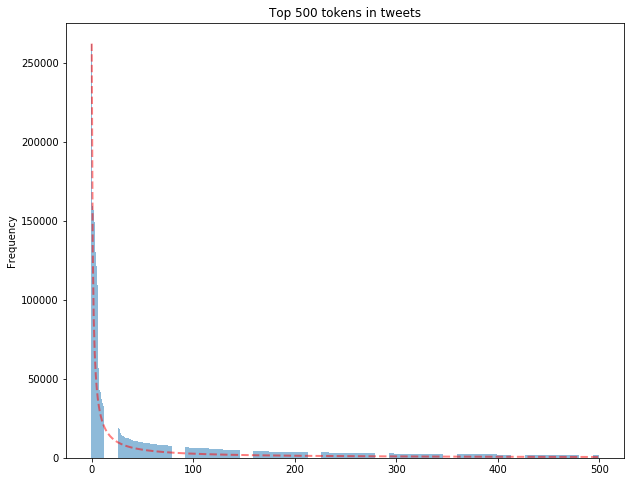

In [174]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')
plt.savefig('zipf.png')

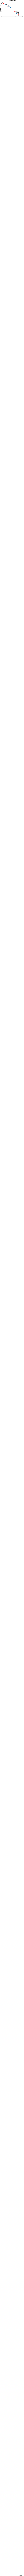

In [175]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for news tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")
plt.savefig('loglog.png')

In [18]:
#count_vect.vocabulary_

In [162]:
vector = count_vect.transform(X)
# summarize encoded vector
#print(vector.shape)


In [20]:
#pd.DataFrame(vector.toarray()).to_csv('balanced_count_vectorized_CONTENT.csv')

In [51]:
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_X)
xtest_count =  count_vect.transform(test_X)

In [52]:
xstest_count =  count_vect.transform(Xs)

In [88]:
##TODO: test max number of features work best
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, min_df=50)
tfidf_vect.fit(X)
xtrain_tfidf =  tfidf_vect.transform(train_X)
xtest_tfidf =  tfidf_vect.transform(test_X)

In [93]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000)
svd.fit(tfidf_vect.fit_transform(X))
xtrain_svd =  svd.transform(train_X)
xtest_svd =  svd.transform(test_X)

ValueError: could not convert string to float: 'all dollar figure in us dollar unless otherwise indicate vancouver march 13 2019 prnewswire equinox gold corp tsx v eqx otc eqxff equinox gold or the company have release -pron- audit consolidated financial statement annual financial statement and related management s discussion and analysis q4 md a for the fourth quarter and fiscal year end december 31 2018 2018 key achievements strong safety record with no lose time incident mesquite gold mine acquisition complete october 30 2018 immediately establish equinox gold as a producer with 25 601 ounce of gold in 2018 generate revenue of 30 2 million follow the acquisition follow the acquisition aurizona gold mine construction substantially complete energized the crusher and commence commission in december 2018 complete pre production mining with more than 750 000 tonne of ore stockpile castle mountain gold mine prefeasibility study complete july 2018 phase 1 year 1 3 average 45 000 ounce of gold production per year phase 2 year 3 16 average 203 000 ounce of gold production per year 763 per ounce life of mine aisc 865 million after tax life of mine cumulative cash flow 1 2 per ounce life of mine aisc after tax life of mine cumulative cash flow 483 increase to proven and probable gold reserve new gold discovery at aurizona and castle mountain monetized non core asset with the koricancha sale spun out copper asset to create solaris copper inc cash and cash equivalent at december 31 2018 of 60 8 million equinox gold s primary objective for 2018 be to transform from a developer to a gold producer say christian milau chief executive officer the mesquite acquisition accelerate that transition bring immediate production and cash flow and significantly increase the company s production profile for 2019 and beyond with first gold pour at aurizona expect in the next few week equinox gold expect to produce more than 230 000 ounce of gold in 2019 and will continue to grow -pron- production profile with castle mountain development exploration success and strategic acquisition aurizona update aurizona construction be substantially complete and plant commissioning be well underway use the exist powerline substation upgrade to support the increase power demand be complete and pend final approval by the state utility first ore have be process through the crush system and the sag and ball mill motor have be fully test the construction team be now complete electrical and instrumentation installation include cable pull in the cip detox and reagent area and final motor and instrument connection the aurizona team have complete more than 1 2 million hour of construction with no lost time injury 2018 financial and operating performance operating result for the three month and year end december 31 20183 year end operating datum from mesquite unit december 31 2018 gold produce oz 25 601 gold sell oz 24 384 realize gold price oz 1 237 cash cost per gold oz sold1 4 oz 723 aisc per gold oz sold1 4 oz 819 consolidated profit and loss datum for the three month and year end december 31 20183 three months end year end profit and loss datum in million except per share figure december 31 2018 december 31 2018 revenue 30 2 30 2 earning from mine operation 8 0 8 0 adjusted ebitda from continue operation 24 0 net loss from continue operation before tax 9 6 21 4 basic loss per share attributable to shareholder share 0 02 0 05 additional information regard the company s financial result activity underway at mesquite aurizona and castle mountain and the company s long term business strategy be available in the annual financial statement and accompany q4 md a which be available for download on the company s website at www equinoxgold com and on sedar at www sedar com 1 cash cost per oz sell and aisc per oz sell be non gaap measure see cash cost and all in sustaining costs in cautionary notes 2 use a 1 250 oz gold price as outline in the july 2018 prefeasibility study entitle ni 43 101 technical report on the preliminary feasibility study for the castle mountain project prepare by kappes cassiday and associates which be available on sedar 3 operating datum revenue and earning from mine operation be the same for the three month and year end december 31 2018 since mesquite be acquire during the fourth quarter on october 30 2018 4 the cash cost and aisc reflect equinox gold s cost of acquire the gold in the leach pad inventory on the date of acquisition and the processing and selling cost associate with gold sell -pron- do not reflect expenditure incur by the previous owner to -pron- and stack those ounce onto the leach pad on behalf of the board of equinox gold corp christian milau ceo director about equinox gold equinox gold be a canadian mining company with a multi million ounce gold reserve base gold production from -pron- mesquite gold mine in california and near term production from two past produce mine in brazil and california commissioning be underway at the company s aurizona gold mine in brazil and the company be advance -pron- castle mountain gold mine in california with the objective of ramp up phase 1 operation in early 2020 further information about equinox gold s portfolio of asset and long term growth strategy be available at www equinoxgold com or by email at ir equinoxgold com cautionary notes neither the tsx venture exchange nor -pron- regulation services provider as such term be define in the policy of the tsx venture exchange accept responsibility for the adequacy or accuracy of this release forward look statement this news release contain certain forward look information and forward look statement within the meaning of applicable security legislation and may include future orient financial information all statement other than statement of historical fact be forward look statement forward look statement or information in this news release relate to among other thing the ability of the company to successfully complete construction and commissioning activity and the plan restart of production at aurizona the ability of the company to successfully operate mesquite include with respect to production development and timing of anticipate production at castle mountain and the growth potential of the company forward look statement or information generally identify by the use of the word will advance plan anticipate expect estimate continue near term ramp up and similar expression and phrase or statement that certain action event or result may should or be achieve or the negative connotation of such term be intend to identify forward look statement and information although the company believe that the expectation reflect in such forward look statement and information be reasonable undue reliance should not be place on forward look statement since the company can give no assurance that such expectation will prove to be correct the company have base these forward look statement and information on the company s current expectation and projection about future event and these assumption include tonnage of ore to be mine and process ore grade and recovery price for gold remain as estimate the construction and plan production at aurizona and castle mountain be complete and perform in accordance with current expectation currency exchange rate remain as estimate availability of fund for the company s project and future cash requirement capital decommissioning and reclamation estimate the company s mineral reserve and resource estimate and the assumption on which -pron- be base price for energy input labour material supply and service no labour relate disruption and no unplanned delay or interruption in schedule development and production all necessary permit license and regulatory approval be receive in a timely manner and the company s ability to comply with environmental health and safety law while the company consider these assumption to be reasonable base on information currently available -pron- may prove to be incorrect reader be caution not to put undue reliance on the forward look statement or information contain in this news release the company caution that forward look statement and information involve know and unknown risk uncertainty and other factor that may because actual result and development to differ materially from those express or imply by such forward look statement or information contain in this news release and the company have make assumption and estimate base on or relate to many of these factor such factor include without limitation fluctuation in gold price fluctuation in price for energy input labour material supply and service fluctuation in currency market operational risk and hazard inherent with the business of mining include environmental accident and hazard industrial accident equipment breakdown usual or unexpected geological or structural formation cave in flooding and severe weather inadequate insurance or inability to obtain insurance to cover these risk and hazard employee relation relationship with and claim by local community and indigenous population the company s ability to obtain all necessary permit license and regulatory approval in a timely manner change in law regulation and government practice include environmental export and import law and regulation legal restriction relate to mining risk relate to expropriation increase competition in the mining industry and those factor identify in the company s management information circular date june 20 2018 and in -pron- md a dated december 31 2018 which be available on sedar at www sedar com forward look statement and information be design to help reader understand management s view as of that time with respect to future event and speak only as of the date -pron- be make except as require by applicable law the company assume no obligation and do not intend to update or to publicly announce the result of any change to any forward look statement or information contain or incorporate by reference to reflect actual result future event or development change in assumption or change in other factor affect the forward look statement and information if the company update any one or more forward look statement no inference should be draw that the company will make additional update with respect to those or other forward look statement all forward look statement and information contain in this news release be expressly qualified in -pron- entirety by this cautionary statement cash costs and all in sustaining costs this news release refer to cash cost and aisc per ounce which be non gaap generally accept accounting principle measure -pron- have no standardized meaning under international financial reporting standards ifrs and may not be comparable to similar measure present by other company this measurement be intend to provide additional information and should not be consider in isolation or as a substitute for measure of performance prepare in accordance with ifrs cash cost include mine site operating cost but be exclusive of amortization reclamation capital and exploration cost and net of by product sale and then divide by ounce sell to arrive at cash cost per ounce aisc start with total cash cost and add net capital expenditure that be sustain in nature mine site general and administrative cost capitalize and expense exploration that be sustain in nature and environmental reclamation cost all divide by ounce sell to arrive at aisc per ounce management believe cash cost and aisc be measure commonly use in the gold mining industry and be useful for monitor the performance of operation and the ability of mine to generate positive cashflow qualified person james jim currie p eng equinox gold s chief operating officer and scott heffernan msc p geo equinox gold s evp exploration be the qualified persons under ni 43 101 for equinox gold and have review approve and verify the technical content of this document source equinox gold corp'

In [87]:
len(TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=None, min_df=50).fit(X).get_feature_names())

5074

In [54]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=None)
tfidf_vect_ngram.fit(X)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_X)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_X)

In [55]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=None)
tfidf_vect_ngram_chars.fit(X)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_X) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_X) 

In [89]:
xstest_tfidf =  tfidf_vect.transform(Xs)
xstest_tfidf_ngram =  tfidf_vect_ngram.transform(Xs)
xstest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(Xs)

In [27]:
#tfidf_vect.vocabulary_

In [28]:
#tfidf_vect.idf_

In [ ]:
# encode document
vector = tfidf_vect.transform(X)
# summarize encoded vector
#print(vector.shape)
#print(vector.toarray())

In [102]:
#pd.DataFrame(vector.toarray()).to_csv('balanced_tfidf_vectorized_CONTENT.csv')

In [22]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(X)

word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_X), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_X), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
test_seq_xs = sequence.pad_sequences(token.texts_to_sequences(Xs), maxlen=70)

In [57]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, feature_vector_suspended, is_neural_net=False, classifier_name=None, feature_vector_name=None):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict the labels on the suspension stock dataset
    suspended_prediction = classifier.predict(feature_vector_suspended)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        suspended_prediction = suspended_prediction.argmax(axis=-1)
    
    accuracy = metrics.accuracy_score(test_y, predictions)
    precision = metrics.precision_score(test_y, predictions, average=None)
    recall = metrics.recall_score(test_y, predictions, average=None)
    f1 = metrics.f1_score(test_y, predictions, average=None)
    
    
    suspended_accuracy = metrics.accuracy_score(test_ys, suspended_prediction)
    suspended_precision = metrics.precision_score(test_ys, suspended_prediction, average=None)
    suspended_recall = metrics.recall_score(test_ys, suspended_prediction, average=None)
    suspended_f1 = metrics.f1_score(test_ys, suspended_prediction, average=None)
    
    df = pd.DataFrame([[classifier_name, feature_vector_name, accuracy,precision,recall,f1, suspended_accuracy, suspended_precision, suspended_recall, suspended_f1]], columns=['classifier','feature vector','accuracy','precision','recall','f1', 'suspended_accuracy', 'suspended_precision', 'suspended_recall', 'suspended_f1'])
    
    return df

In [58]:
metrics_df = pd.DataFrame(columns=['classifier', 'feature vector', 'accuracy', 'precision', 'recall', 'f1', 'suspended_accuracy', 'suspended_precision', 'suspended_recall', 'suspended_f1'])

In [59]:
# Naive Bayes on Count Vectors
scores = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count, xstest_count, classifier_name='Naive Bayes', feature_vector_name='Count')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [90]:
# Naive Bayes on word level TF-IDF Vectors
scores = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf, xstest_tfidf, classifier_name='Naive Bayes', feature_vector_name='word TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [61]:
# Naive Bayes on ngram level TF-IDF Vectors
scores = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram, xstest_tfidf_ngram, classifier_name='Naive Bayes', feature_vector_name='ngram TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [62]:
# Naive Bayes on characters level TF-IDF Vectors
train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars, xstest_tfidf_ngram_chars, classifier_name='Naive Bayes', feature_vector_name='chars TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [35]:
# Logistic Regression on Count Vectors
scores = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count, xstest_count, classifier_name='Logistic Regression', feature_vector_name='Count')
metrics_df = metrics_df.append(scores, ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [36]:
# Logistic Regression on TF-IDF Vectors
scores = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf, xstest_tfidf, classifier_name='Logistic Regression', feature_vector_name='TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [ ]:
# SVM on Ngram Level TF IDF Vectors
scores = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram, xstest_tfidf_ngram, classifier_name='SVM', feature_vector_name='ngram TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [37]:
# Random Forest on Count Vectors
scores = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count, xstest_count, classifier_name='Random Forest', feature_vector_name='Count')
metrics_df = metrics_df.append(scores, ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
# Random Forest on TF-IDF Vectors
scores = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf, xstest_tfidf, classifier_name='Random Forest', feature_vector_name='word TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [39]:
# Extreme Boosting Gradient on Count Vectors
scores = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc(), xstest_count.tocsc(), classifier_name='Extreme Boosting Gradient', feature_vector_name='Count')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [40]:
# Extreme Boosting Gradient on TF-IDF Vectors
scores = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xtest_tfidf.tocsc(), xstest_tfidf.tocsc(), classifier_name='Extreme Gradient Boosting', feature_vector_name='word TF-IDF')
metrics_df = metrics_df.append(scores, ignore_index=True)

In [91]:
metrics_df

,classifier,feature vector,accuracy,precision,recall,f1,suspended_accuracy,suspended_precision,suspended_recall,suspended_f1
0,Naive Bayes,Count,0.466974,"[0.4965197215777262, 0.4308510638297872, 0.491...","[0.4766146993318486, 0.5560640732265446, 0.362...","[0.4863636363636364, 0.4855144855144855, 0.417...",0.332432,"[0.31555555555555553, 0.45, 0.15555555555555556]","[0.6120689655172413, 0.24456521739130435, 0.1]","[0.4164222873900293, 0.3169014084507042, 0.121..."
1,Naive Bayes,word TF-IDF,0.474654,"[0.568561872909699, 0.43386243386243384, 0.463...","[0.37861915367483295, 0.562929061784897, 0.485...","[0.4545454545454545, 0.49003984063745015, 0.47...",0.391892,"[0.3687150837988827, 0.5350877192982456, 0.233...","[0.5689655172413793, 0.33152173913043476, 0.25...","[0.44745762711864406, 0.4093959731543624, 0.24..."
2,Naive Bayes,ngram TF-IDF,0.497696,"[0.5835866261398176, 0.46112115732368897, 0.47...","[0.42761692650334077, 0.5835240274599542, 0.48...","[0.49357326478149094, 0.5151515151515152, 0.48...",0.351351,"[0.3591549295774648, 0.4806201550387597, 0.171...","[0.4396551724137931, 0.33695652173913043, 0.24...","[0.39534883720930236, 0.3961661341853035, 0.20..."
3,Naive Bayes,ngram TF-IDF,0.497696,"[0.5835866261398176, 0.46112115732368897, 0.47...","[0.42761692650334077, 0.5835240274599542, 0.48...","[0.49357326478149094, 0.5151515151515152, 0.48...",0.351351,"[0.3591549295774648, 0.4806201550387597, 0.171...","[0.4396551724137931, 0.33695652173913043, 0.24...","[0.39534883720930236, 0.3961661341853035, 0.20..."
4,Naive Bayes,word TF-IDF,0.456221,"[0.5164835164835165, 0.41551724137931034, 0.46...","[0.41870824053452116, 0.551487414187643, 0.396...","[0.4624846248462485, 0.47394296951819076, 0.42...",0.386486,"[0.35858585858585856, 0.5238095238095238, 0.25...","[0.6120689655172413, 0.29891304347826086, 0.24...","[0.4522292993630573, 0.3806228373702422, 0.248..."
5,Naive Bayes,word TF-IDF,0.453917,"[0.5065963060686016, 0.41708542713567837, 0.46...","[0.42761692650334077, 0.5697940503432495, 0.36...","[0.46376811594202905, 0.48162475822050294, 0.4...",0.386486,"[0.3523809523809524, 0.5408163265306123, 0.258...","[0.6379310344827587, 0.28804347826086957, 0.22...","[0.45398773006134974, 0.375886524822695, 0.242..."


In [62]:
# label order ['negative', 'neutral', 'positive']
#metrics_df.to_csv('metrics_scores.csv')

In [131]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))
    #input_layer = layers.Input(X.shape)
    
    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=True)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(3, activation="softmax")(lstm_layer)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [134]:
classifier = create_rnn_lstm()
#accuracy = train_model(classifier, train_seq_x, train_y, test_seq_x, test_seq_xs, is_neural_net=True, classifier_name='LSTM', feature_vector_name='fastText embedding')
#print("RNN-LSTM, Word Embeddings",  accuracy)
classifier.fit(train_seq_x, train_y)

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
568/568 [==============================] - 3s 6ms/step - loss: 1.0734 - accuracy: 0.3944


In [136]:
predictions = classifier.predict(test_seq_x)

In [74]:
x_train_tfidf = TfidfVectorizer(max_features=60000,ngram_range=(1, 3)).fit_transform(train_X)

In [75]:
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
chi2score = chi2(x_train_tfidf, train_y)[0]

Text(0.5, 0, '$\\chi^2$')

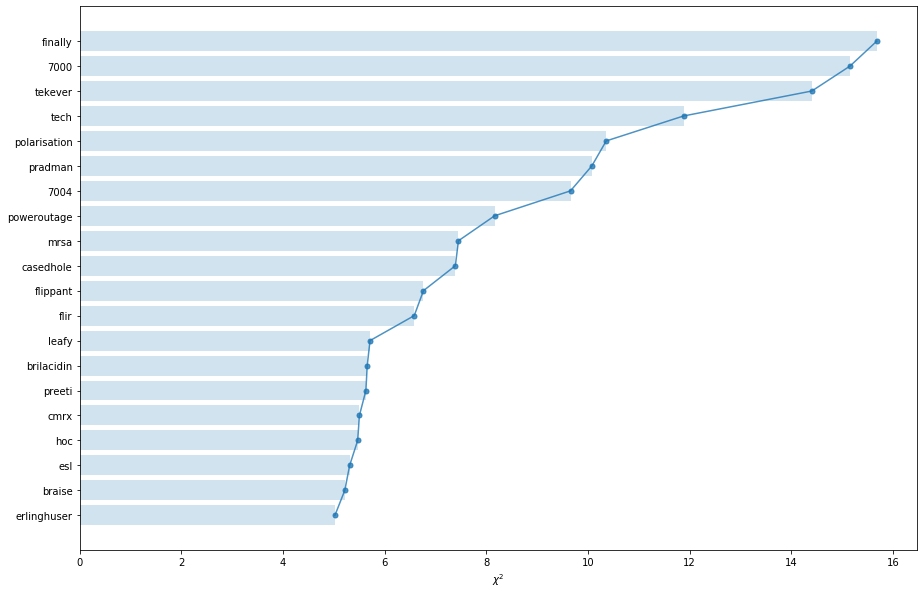

In [76]:
wscores = list(zip(tfidf_vect.get_feature_names(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.figure(figsize=(15,10))
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [77]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(10000,70000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(xtrain_tfidf, train_y)
    x_validation_chi2_selected = ch2.transform(xstest_tfidf)
    clf = linear_model.LogisticRegression()
    clf.fit(x_train_chi2_selected, train_y)
    score = clf.score(x_validation_chi2_selected, test_ys)
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 10000 features


/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 20000 features


/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 30000 features


/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 40000 features


/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 50000 features


/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/albert/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 60000 features


In [78]:
ch2_result

[0.3621621621621622,
 0.36486486486486486,
 0.372972972972973,
 0.34864864864864864,
 0.33783783783783783,
 0.3567567567567568]

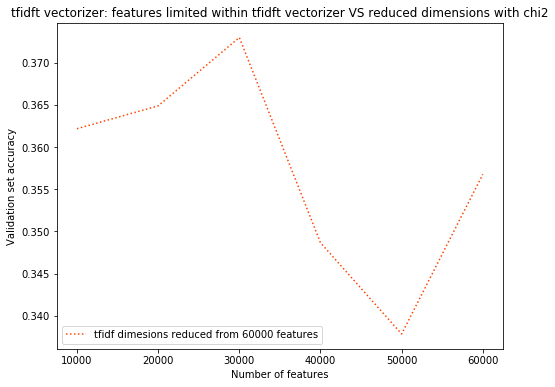

In [73]:
plt.figure(figsize=(8,6))
#plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,70000,10000), ch2_result,label='tfidf dimesions reduced from 60000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
xgboost draw feature importance plot 
consider which features are important

pca, chi2

